<a href="https://colab.research.google.com/github/IkeLyons/Wine-Quality-Neural-Net/blob/main/WineQualityNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources Used

https://www.educative.io/blog/one-hot-encoding

I decided to use one hot encoding in my project as I wanted the neural net to try to get the rating exactly correct to what the reviewers had, and wanted the neural net to see the 10 different ratings as "categories". The revieweres seemed to use the same numbers often, and I wanted my neural net to mimic their behavior as closely as possible

https://www.tensorflow.org/api_docs/python/tf/Variable
https://www.tensorflow.org/guide/variable

The tensorflow variable is a crucial resource that I am using from the tensorflow library. They are used to represent the weights and bias layers and can be connected together to form the whole neural network.


https://www.tensorflow.org/api_docs/python/tf/random/truncated_normal

This is the resource I used in order to initialize the weights of my hidden layer. I used this resource because as we learned you cannot initalize the values to 0, and this random inializer is tensorflows recommended initializer method for Neural Netowrk weights. 

https://www.tensorflow.org/api_docs/python/tf/linalg/matmul

Matmul is used in order to multiply matricies. I used this resource when I was "connecting" the layers by finding "z = W x A + b" in combination with the activiation function.

https://www.tensorflow.org/api_docs/python/tf/nn

I used the tensorflow nn package for multiple different neural net related math operations. Namely, I used the sigmoid (as well as relu and tanh during testing) and softmax cross entropy functions. These were required for the activiation function and the loss function.

https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/AdamOptimizer

I used the tensorflow train resource for different optimization algorithms and eventually settled on using the adam optimizer.

# Data seleection and importing

In this project we are going to attempt to predict the quality of white wines on a scale of 1 to 10. The dataset includes a number of chemical indicators that might be useful in determining the quality of a white wine.

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download brendan45774/wine-quality

wine-quality.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip wine-quality.zip

Archive:  wine-quality.zip
replace winequality-red.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace winequality-white.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
dataset = pd.read_csv('winequality-white.csv', encoding='utf-8', sep=";")
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Exploratory Data Analysis

In [ ]:
dataset.shape

(4898, 12)

In [ ]:
dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [ ]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Apply Mean Normalization:

In [ ]:
quality = dataset['quality']
dataset=(dataset-dataset.mean())/dataset.std()
dataset['quality'] = quality
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.172079,-0.081762,0.213258,2.821061,-0.035351,0.569873,0.744489,2.331274,-1.246794,-0.349149,-1.393010,6
1,-0.657434,0.215874,0.047996,-0.944669,0.147732,-1.252891,-0.149669,-0.009153,0.739953,0.001342,-0.824192,6
2,1.475600,0.017450,0.543783,0.100272,0.193503,-0.312109,-0.973236,0.358628,0.475053,-0.436771,-0.336633,6
3,0.409083,-0.478608,-0.117266,0.415726,0.559670,0.687471,1.120977,0.525802,0.011479,-0.787262,-0.499152,6
4,0.409083,-0.478608,-0.117266,0.415726,0.559670,0.687471,1.120977,0.525802,0.011479,-0.787262,-0.499152,6


# Train-Dev-Test Split

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

num_features = dataset.shape[1]
X = dataset[dataset.columns[0:num_features - 1]].values
y = dataset[dataset.columns[num_features - 1]].values

# one hot encoding
encode = np.zeros((len(y), 10))
encode[np.arange(len(y)), y] = 1
y = encode
print(y)

X, y = shuffle(X, y, random_state=1)
# train: 80%, val: 10%, test: 10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Forward Propagation Implementation

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Also note that the hyperparameters are being defined here.

In [ ]:
import tensorflow as tf

epochs = 250
batchSize = 50
learningRate = 0.01
hiddenLayerSize = 26
outputSize = 10
num_features = X_train.shape[1]

W1 = tf.Variable(tf.truncated_normal([hiddenLayerSize, num_features], dtype=tf.float32, name='Weights1', stddev=0.1))
b1 = tf.Variable(tf.zeros([hiddenLayerSize], tf.float32), name='bias1')
W2 = tf.Variable(tf.zeros([outputSize, hiddenLayerSize], tf.float32, name='Weights2'))
b2 = tf.Variable(tf.zeros([outputSize], tf.float32), name='bias2')

x = tf.placeholder(tf.float32, shape=[None, num_features], name='X')
y = tf.placeholder(tf.float32, shape=[None, outputSize], name='Y')

ConnectedHidden = tf.nn.sigmoid(tf.add(tf.matmul(x, W1, transpose_b=True), b1))
output = tf.matmul(ConnectedHidden, W2, transpose_b=True) + b2

# Implementing Mini-Batch Gradient Descent and Computing Final Cost and Accuracy

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate, name='Adam-op').minimize(loss)
correct = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

accuracyHistory = []
lossHistory = []
prediction = tf.argmax(output, axis=1, name='predictions')
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

import numpy as np

numIters = int(len(y_train) / batchSize)
for epoch in range(epochs + 1):
  X_train, y_train = shuffle(X_train, y_train, random_state=1)
  for iter in range(numIters):
    xBatch = X_train[iter * batchSize: (iter + 1) * batchSize]
    yBatch = y_train[iter * batchSize: (iter + 1) * batchSize]

    sess.run(optimizer, feed_dict={x: xBatch, y: yBatch})
    loss_batch, acc_batch = sess.run([loss, accuracy], feed_dict={x: xBatch, y: yBatch})
    accuracyHistory.append(acc_batch)
    lossHistory.append(loss_batch)
  if epoch % 50 == 0:
      
      print("--------------------------------------------------------")
      print("epoch {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".format(epoch, loss_batch, acc_batch))
      print("--------------------------------------------------------")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

--------------------------------------------------------
epoch   0:	 Loss=1.16,	Training Accuracy=44.0%
--------------------------------------------------------
--------------------------------------------------------
epoch  50:	 Loss=1.12,	Training Accuracy=50.0%
--------------------------------------------------------
--------------------------------------------------------
epoch 100:	 Loss=1.09,	Training Accuracy=52.0%
--------------------------------------------------------
--------------------------------------------------------
epoch 150:	 Loss=0.96,	Training Accuracy=60.0%
--------------------------------------------------------
--------------------------------------------------------
epoch 200:	 Loss=0.85,	Training Accuracy=54.0%
--------------------------------------------------------
----

# Presenting Results

In [ ]:
print("Valadation Accuracy: ", (sess.run(accuracy, feed_dict={x: X_val, y: y_val})))

Valadation Accuracy:  0.5387755


Only run the accuracy when you are done using the valadation data for making adjustments to the model

In [ ]:
print("Test Accuracy: ", (sess.run(accuracy, feed_dict={x: X_test, y: y_test})))

Test Accuracy:  0.5367347


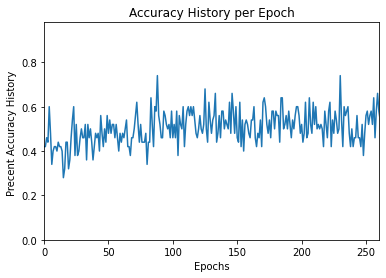

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(accuracyHistory)), accuracyHistory)
plt.xlabel('Epochs')
plt.ylabel('Precent Accuracy History ')
plt.title("Accuracy History per Epoch")
plt.xlim(0, epochs + 10)
plt.ylim(0, np.max(accuracyHistory)+0.1)
plt.rcParams['figure.figsize'] = [12, 5]
plt.show()

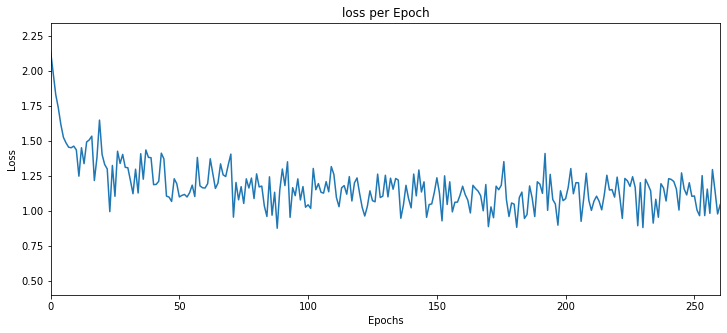

In [ ]:
plt.plot(range(len(lossHistory)), lossHistory)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("loss per Epoch")
plt.xlim(0, epochs + 10)
plt.ylim(0.4, np.max(lossHistory)+0.2)
plt.rcParams['figure.figsize'] = [12, 5]
plt.show()

# Conclusion

I originally began without, and did a lot of my testing without any data regularization. I thought that the values were similar enough in scale for it to not make a difference. I then tested using it, and found that the minimum loss the neural net was acheiving was lower. I also found that the maximum accuracy increased. I think the reason the regularization made a difference was that some of th columns had values all between 0 and 1 whereas some were between 0-10. I didn't think this was a significant difference in scale but changing it slightly improved my model and thus I kept it.